# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

np.random.seed(1)

In [2]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = {k: v for v, k in enumerate(self.word2vec.keys())}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))

    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        scores = np.zeros(self.embeddings.shape[0])
        for i, word in enumerate(self.word2id.keys()):
            scores[i] = self.score(w, word)
        # argsort returns a result corresponding to the ascending order. We then
        # add a - sign to the score array.
        # We also start to 1 to avoid returning the word itself.
        return [self.id2word[top_id] for top_id in np.argsort(-scores)[1:K+1]]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        embedding_w1 = self.get_embeddings(w1)
        embedding_w2 = self.get_embeddings(w2)
        return np.dot(embedding_w1, embedding_w2) / (
            np.linalg.norm(embedding_w1) * np.linalg.norm(embedding_w2))
    
    def get_embeddings(self, word):
        return self.embeddings[self.word2id.get(word), :]

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'),
                  ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288558
germany berlin 0.7420295235998394
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'pooches', 'Dogs', 'doggies', 'canines']
['france', 'Paris', 'london', 'berlin', 'tokyo']
['austria', 'europe', 'german', 'berlin', 'poland']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v

    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            words_in_w2v = [
                word for word in sent.split()
                if word in self.w2v.word2id.keys()
            ]
            if idf is False:
                sentemb.append(
                    np.mean([
                        self.w2v.get_embeddings(word) for word in words_in_w2v
                    ],
                            axis=0))
            else:
                # idf-weighted mean of word vectors
                idf_weights = [idf[word] for word in words_in_w2v]
                sentemb.append(
                    np.average([
                        self.w2v.get_embeddings(word) for word in words_in_w2v
                    ],
                               weights=idf_weights,
                               axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        scores = np.zeros(len(sentences))
        for i, sentence in enumerate(sentences):
            scores[i] = self.score(s, sentence, idf)
        # argsort returns a result corresponding to the ascending order. We then
        # add a - sign to the score array.
        # We also start to 1 to avoid returning the word itself.
        return [sentences[top_id] for top_id in np.argsort(-scores)[1:K + 1]]

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        embedding_s1 = self.encode([s1], idf)[0]
        embedding_s2 = self.encode([s2], idf)[0]
        return np.dot(embedding_s1, embedding_s2) / (
            np.linalg.norm(embedding_s1) * np.linalg.norm(embedding_s2))

    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        counts = {}
        for sent in sentences:
            for w in sent.split():
                counts[w] = counts.get(w, 0) + 1

        idf = {
            word: max(1, np.log10(len(sentences) / (count)))
            for word, count in counts.items()
        }

        return idf

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=50000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with io.open(os.path.join(PATH_TO_DATA, 'sentences.txt'), encoding='utf-8') as f:
    sentences = f.read().splitlines()

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print('\nBoV-mean\n')

print('Query : {}'.format(sentences[10]))
print('Most similar :')
most_similar = s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
for s in most_similar:
    print(s)

print('\nScores : \n{}\n{}'.format(sentences[7], sentences[13]))
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


print('\n\nBoV-idf\n')

idf = s2v.build_idf(sentences)
print('Query : {}'.format(sentences[10]))
print('Most similar :')
most_similar = s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
for s in most_similar:
    print(s)

print('\nScores : \n{}\n{}'.format(sentences[7], sentences[13]))
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 50000 pretrained word vectors

BoV-mean

Query : 1 smiling african american boy . 
Most similar :
an african american man smiling . 
a little african american boy and girl looking up . 
an african american in sunglasses and a white tee-shirt smiles . 
an afican american woman standing behind two small african american children . 
an african american man is sitting . 

Scores : 
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.5726258859719607


BoV-idf

Query : 1 smiling african american boy . 
Most similar :
an african american man smiling . 
an african american man is sitting . 
a little african american boy and girl looking up . 
an afican american woman standing behind two small african american children . 
an african american woman braiding another african american woman 's hair , while sitting in a white chair . 

Scores : 
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [59]:
# 1 - Download and load 50k first vectors of
# !wget -P ./data/ https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
# !wget -P ./data/ https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

def extract_vectors(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

fr_embeddings, fr_id2word, fr_word2id = extract_vectors(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'))
en_embeddings, en_id2word, en_word2id = extract_vectors(os.path.join(PATH_TO_DATA, 'wiki.en.vec'))

In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

common_words = set(fr_word2id.keys()) & set(en_word2id.keys())

print('{} common words'.format(len(common_words)))

X, Y = [], []

for word in common_words:
    X.append(fr_embeddings[fr_word2id[word], :])
    Y.append(en_embeddings[en_word2id[word], :])

X, Y = np.array(X), np.array(Y)

18970 common words


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

from scipy import linalg
U, s, Vh = linalg.svd(Y.T @ X)
W = np.dot(U, Vh)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

src_word = 'spectacle'
np.dot(W, fr_embeddings[fr_word2id[word], :])


transposed_fr_embeddings = np.dot(fr_embeddings, W.T)
        
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word], :]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

print("French --> English\n\n")
french_words = ['chat', 'chien', 'roi', 'spectacle', 'fleur']
for src_word in french_words :
    get_nn(src_word, transposed_fr_embeddings, fr_id2word, en_embeddings, en_id2word, K=5)
    print('')
    
print("\nEnglish --> French\n\n")
english_words = ['cat', 'hurricane', 'queen', 'computer', 'hills']
for src_word in english_words :
    get_nn(src_word, en_embeddings, en_id2word, transposed_fr_embeddings, fr_id2word, K=5)
    print('')

French --> English


Nearest neighbors of "chat":
0.5652 - cat
0.5337 - rabbit
0.5168 - hamster
0.5077 - feline
0.5055 - poodle

Nearest neighbors of "chien":
0.6543 - dog
0.5615 - poodle
0.5610 - terrier
0.5477 - dogs
0.5218 - spaniel

Nearest neighbors of "roi":
0.6827 - king
0.5404 - vassal
0.5363 - kingship
0.5277 - throne
0.5275 - usurper

Nearest neighbors of "spectacle":
0.6300 - vaudeville
0.6257 - concert
0.6168 - spectacle
0.6085 - pantomime
0.6078 - extravaganza

Nearest neighbors of "fleur":
0.6220 - flower
0.5941 - flowers
0.5739 - rosette
0.5652 - flowered
0.5554 - petals


English --> French


Nearest neighbors of "cat":
0.6663 - cat
0.5652 - chat
0.4903 - dog
0.4673 - chats
0.4660 - chien

Nearest neighbors of "hurricane":
0.7552 - ouragan
0.7060 - cyclone
0.6719 - ouragans
0.6380 - cyclonique
0.6112 - tempête

Nearest neighbors of "queen":
0.6639 - queen
0.6461 - reine
0.5241 - princess
0.5120 - princesse
0.5013 - reines

Nearest neighbors of "computer":
0.7132 - compu

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_dataset(filename, is_test=False):
    X, y = [], []
    with io.open(os.path.join(PATH_TO_DATA, filename), newline='\n', encoding='utf-8') as f:
        for line in f:
            if is_test:
                X.append(line.rstrip())
            else:
                cat, sentence = line.split(' ', 1)
                y.append(cat)
                X.append(sentence.rstrip())
    return X, y
            
X_train_sentences, y_train = load_dataset('./SST/stsa.fine.train')
X_dev_sentences, y_dev = load_dataset('./SST/stsa.fine.dev')
X_test_sentences, _ = load_dataset('./SST/stsa.fine.test.X', is_test=True)

In [12]:
# 2 - Encode sentences with the BoV model above

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=500000)
s2v = BoV(w2v)

X_train = s2v.encode(X_train_sentences)
X_dev = s2v.encode(X_dev_sentences)
X_test = s2v.encode(X_test_sentences)

# with idf
idf = s2v.build_idf(X_train_sentences + X_dev_sentences + X_test_sentences)
X_train_idf = s2v.encode(X_train_sentences, idf)
X_dev_idf = s2v.encode(X_dev_sentences, idf)
X_test_idf = s2v.encode(X_test_sentences, idf)

Loaded 200000 pretrained word vectors


### Mean

In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(solver='lbfgs', C=1, penalty='l2', 
                            multi_class='multinomial', max_iter=500)
# grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l2"]}
# logreg = GridSearchCV(logreg, grid, cv=10)
logreg.fit(X_train, y_train)

score = logreg.score(X_train, y_train)
print("Train score : %.4f" % score)
score = logreg.score(X_dev, y_dev)
print("Dev score : %.4f\n" % score)

# print(logreg.best_params_)

Train score : 0.4992
Dev score : 0.4405



### idf

In [14]:
logreg_idf = LogisticRegression(solver='lbfgs', C=1, penalty='l2', 
                                multi_class='multinomial', max_iter=500)
# grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l2"]}
# logreg_idf = GridSearchCV(logreg, grid, cv=10)
logreg_idf.fit(X_train_idf, y_train)

score = logreg_idf.score(X_train_idf, y_train)
print("Train score : %.4f" % score)
score = logreg_idf.score(X_dev_idf, y_dev)
print("Dev score : %.4f\n" % score)

# print(logreg_idf.best_params_)

Train score : 0.4993
Dev score : 0.4233



In [15]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# Not using idf gives the best results, so we save this version
y_test = logreg.predict(X_test).astype(str)
np.savetxt('./data/output/logreg_bov_y_test_sst.txt', y_test, fmt='%s')

In [16]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.svm import SVC

svc = SVC(gamma='scale', C=10)
# grid = {"C": np.logspace(-1, 3, 4)}
# svc = GridSearchCV(svc, grid, cv=8, verbose=1)
svc.fit(X_train, y_train)

score = svc.score(X_train, y_train)
print("Train score : %.4f" % score)
score = svc.score(X_dev, y_dev)
print("Dev score : %.4f\n" % score)

# print(svc.best_params_)

Train score : 0.5012
Dev score : 0.4432



In [17]:
y_test = svc.predict(X_test).astype(str)
np.savetxt('./data/output/SVC_bov_y_test_sst.txt', y_test, fmt='%s')

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)

score = rf.score(X_train, y_train)
print("Train score : %.4f" % score)
score = rf.score(X_dev, y_dev)
print("Dev score : %.4f\n" % score)

Train score : 1.0000
Dev score : 0.3860



In [19]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('logreg', logreg), ('svc', svc), ('rf', rf)], 
                        voting='hard')
eclf.fit(X_train, y_train)

score = eclf.score(X_train, y_train)
print("Train score : %.4f" % score)
score = eclf.score(X_dev, y_dev)
print("Dev score : %.4f\n" % score)

Train score : 0.5648
Dev score : 0.4405



# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [8]:
import keras

Using TensorFlow backend.


In [9]:
# 1 - Load train/dev/test sets of SST
from sklearn.preprocessing import LabelBinarizer

PATH_TO_DATA = "./data/"

def load_dataset(filename, is_test=False):
    X, y = [], []
    with io.open(os.path.join(PATH_TO_DATA, filename), newline='\n', encoding='utf-8') as f:
        for line in f:
            if is_test:
                X.append(line.rstrip())
            else:
                cat, sentence = line.split(' ', 1)
                y.append(int(cat))
                X.append(sentence.rstrip())
    if not is_test:
        y = LabelBinarizer().fit(range(5)).transform(y)
    return X, y
            
X_train_sentences, y_train = load_dataset('./SST/stsa.fine.train')
X_dev_sentences, y_dev = load_dataset('./SST/stsa.fine.dev')
X_test_sentences, _ = load_dataset('./SST/stsa.fine.test.X', is_test=True)

In [10]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X_train_sentences + X_dev_sentences + X_test_sentences)

vocab_size = int(1.2 * len(tokenizer_obj.word_index)) # larger than the number of words to avoid collisions

X_train = [one_hot(x, n=vocab_size) for x in X_train_sentences]
X_dev = [one_hot(x, n=vocab_size) for x in X_dev_sentences]
X_test = [one_hot(x, n=vocab_size) for x in X_test_sentences]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [11]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences

max_len = max([len(x) for x in X_train + X_dev])
print('max len : {}'.format(max_len))

X_train = pad_sequences(X_train, maxlen=max_len)
X_dev = pad_sequences(X_dev, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

max len : 49


## 4.2 - Design and train your model

In [14]:
# Helper function to plot the history

import matplotlib.pyplot as plt 

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16,6)

def plot_history(history):
  """Helper function to plot the accuracy and loss"""
  f, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(history.history['acc'])
  ax1.plot(history.history['val_acc'])
  ax1.set_title('Model Accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['Train', 'Validation'], loc='upper left')

  # summarize history for loss
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('Model Loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [53]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300  # word embedding dimension
nhid       = 50  # number of hidden units in the LSTM
# vocab_size = 0  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))


In [54]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 300)         6421800   
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 255       
Total params: 6,492,255
Trainable params: 6,492,255
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 128
n_epochs = 2

history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/2
8544/8544 [==============================] - 12s 1ms/step - loss: 1.5723 - acc: 0.2870 - val_loss: 1.5460 - val_acc: 0.3015
Epoch 2/2
8544/8544 [==============================] - 10s 1ms/step - loss: 1.4035 - acc: 0.3938 - val_loss: 1.3884 - val_acc: 0.3815


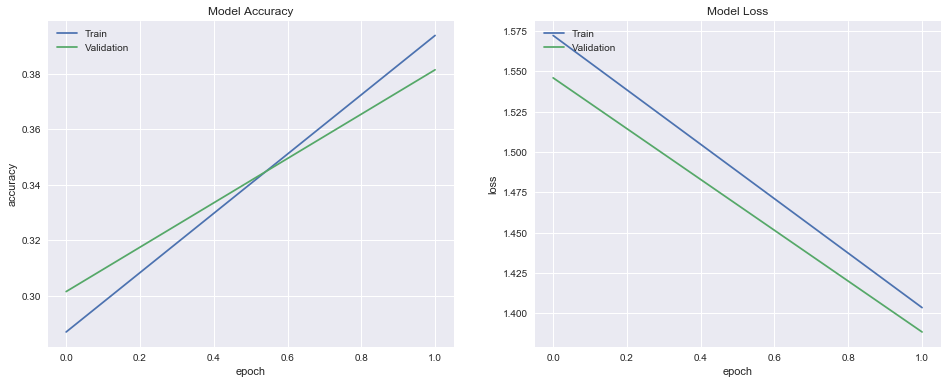

In [56]:
plot_history(history)

In [57]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

y_test = np.argmax(model.predict(X_test), axis=1)
np.savetxt('./data/output/logreg_lstm_y_test_sst.txt', y_test.astype(str), fmt='%s')


## 4.3 -- innovate !

In [60]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

PATH_TO_DATA = "./data/"

def load_dataset(filename, is_test=False):
    X, y = [], []
    with io.open(os.path.join(PATH_TO_DATA, filename), newline='\n', encoding='utf-8') as f:
        for line in f:
            if is_test:
                X.append(line.rstrip())
            else:
                cat, sentence = line.split(' ', 1)
                y.append(int(cat))
                X.append(sentence.rstrip())
    if not is_test:
        y = LabelBinarizer().fit(range(5)).transform(y)
    return X, y
            
X_train_sentences, y_train = load_dataset('./SST/stsa.fine.train')
X_dev_sentences, y_dev = load_dataset('./SST/stsa.fine.dev')
X_test_sentences, _ = load_dataset('./SST/stsa.fine.test.X', is_test=True)

embeddings, id2word, word2id = extract_vectors(os.path.join(PATH_TO_DATA, 'wiki.en.vec'))

vocabulary_size = 5000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X_train_sentences + X_dev_sentences + X_test_sentences)


embedding_matrix = np.zeros((vocabulary_size, embeddings.shape[1]))

for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        idx_embedding = word2id.get(word)
        if idx_embedding is not None:
            embedding_matrix[index, :] = embeddings[idx_embedding, :]
            
X_train = tokenizer.texts_to_sequences(X_train_sentences)
X_train = pad_sequences(X_train, maxlen=50)

X_dev = tokenizer.texts_to_sequences(X_dev_sentences)
X_dev = pad_sequences(X_dev, maxlen=50)

X_test = tokenizer.texts_to_sequences(X_test_sentences)
X_test = pad_sequences(X_test, maxlen=50)

In [64]:
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten

model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, embeddings.shape[1], input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(128, 3, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(10, dropout = 0.2, recurrent_dropout = 0.2))
model_glove.add(Dense(5, activation='sigmoid'))

model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
history = model_glove.fit(X_train, y_train, epochs=6, batch_size=32, validation_data=(X_dev, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 8s 896us/step - loss: 1.5196 - acc: 0.3297 - val_loss: 1.4208 - val_acc: 0.3769
Epoch 2/6
8544/8544 [==============================] - 5s 639us/step - loss: 1.4099 - acc: 0.3831 - val_loss: 1.3636 - val_acc: 0.3878
Epoch 3/6
8544/8544 [==============================] - 6s 659us/step - loss: 1.3468 - acc: 0.3947 - val_loss: 1.3216 - val_acc: 0.3933
Epoch 4/6
8544/8544 [==============================] - 6s 665us/step - loss: 1.3023 - acc: 0.4100 - val_loss: 1.3855 - val_acc: 0.3642
Epoch 5/6
8544/8544 [==============================] - 6s 661us/step - loss: 1.2487 - acc: 0.4230 - val_loss: 1.3133 - val_acc: 0.3969
Epoch 6/6
8544/8544 [==============================] - 6s 662us/step - loss: 1.2094 - acc: 0.4362 - val_loss: 1.2982 - val_acc: 0.4069


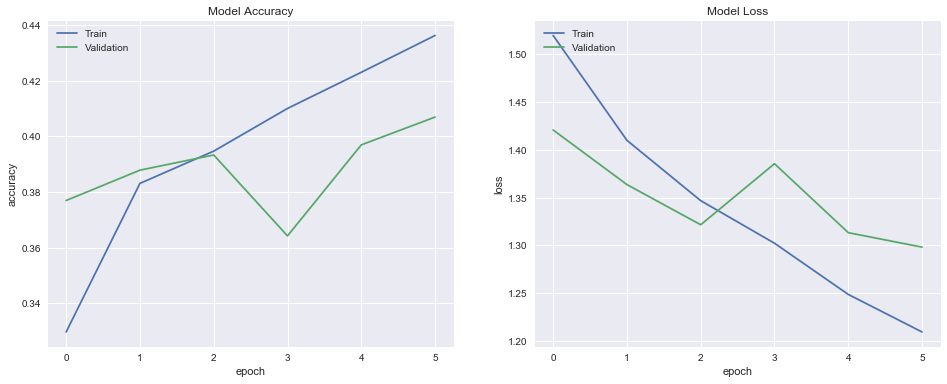

In [66]:
plot_history(history)

In [67]:
y_test = np.argmax(model.predict(X_test), axis=1)
np.savetxt('./data/output/convnet_lstm_y_test_sst.txt', y_test.astype(str), fmt='%s')